## 案例一：GDP增长预测

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

#设置中文字体和图标样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

In [46]:
print("=" * 60)
print("GM(1,1)灰色预测模型 - GDP增长预测案例")
print("=" * 60)

GM(1,1)灰色预测模型 - GDP增长预测案例


In [ ]:
class GM11:
    '''
    GM(1,1)灰色预测模型类
    
    主要功能：
    1.级比检验
    2.累加生成 均值生成
    3.参数估计
    4.模型训练
    5.预测计算
    6.精度检验
    7.结果可视化
    '''
    
    def __init_(self):
        self.a = None  #发展系数
        self.b = None  #灰色作用量
        self.x0 = None #原始数据
        self.n = None  #数据长度
        self.fitted_values = None #拟合值
        
    def level_ratio_test(self, data):
        """
        级比检验函数
        
        参数:
        data: 原始数据序列
        
        返回:
        valid: 是否通过检验
        level_ratios: 级比序列
        bounds: 检验边界
        """
        n = len(data)
        level_ratios = []
        
        # 计算级比
        for i in range(1, n):
            if data[i] != 0:  # 避免除零错误
                ratio = data[i-1] / data[i]
                level_ratios.append(ratio)
        
        # 计算检验边界
        lower_bound = np.exp(-2/(n+1))
        upper_bound = np.exp(2/(n+1))
        bounds = (lower_bound, upper_bound)
        
        # 检验是否在合理范围内
        valid = all(lower_bound <= ratio <= upper_bound for ratio in level_ratios)
        
        print(f"级比检验结果:")
        print(f"检验边界: ({lower_bound:.3f}, {upper_bound:.3f})")
        print(f"级比序列: {[f'{r:.3f}' for r in level_ratios]}")
        print(f"检验结果: {'通过' if valid else '不通过'}")
        
        return valid, level_ratios, bounds
    
    def fit(self, data):
        """
        训练GM(1,1)模型
        
        参数:
        data: 原始数据序列
        """
        self.x0 = np.array(data, dtype=float)
        self.n = len(data)
        
        print(f"\n原始数据: {self.x0}")
        
        # 级比检验
        valid, ratios, bounds = self.level_ratio_test(data)
        if not valid:
            print("⚠️  警告：数据未通过级比检验，模型预测精度可能较低！")
        
        # 一次累加生成
        self.x1 = np.cumsum(self.x0)
        print(f"累加生成序列: {self.x1}")
        
        # 构造均值序列Z(1)
        z1 = []
        for i in range(1, self.n):
            z1.append((self.x1[i] + self.x1[i-1]) / 2)
        z1 = np.array(z1)
        print(f"均值序列Z(1): {z1}")
        
        # 构造数据矩阵B和向量Y
        B = np.column_stack((-z1, np.ones(len(z1))))
        Y = self.x0[1:]  # 从第二个数据开始
        
        print(f"\n数据矩阵B形状: {B.shape}")
        print(f"\n数据矩阵B: {B}")
        print(f"观测向量Y: {Y}")
        
        # 最小二乘估计参数
        try:
            # 使用伪逆求解，更稳定
            params = np.linalg.lstsq(B, Y, rcond=None)[0]
            [self.a, self.b] = params
        except np.linalg.LinAlgError:
            print("❌ 参数估计失败，请检查数据质量")
            return
        
        print(f"\n模型参数估计结果:")
        print(f"发展系数 a = {self.a:.6f}")
        print(f"灰作用量 b = {self.b:.6f}")
        
        # 判断模型特性
        if self.a > 0:
            print("📈 模型特性: 衰减型（数据呈下降趋势）")
        else:
            print("📊 模型特性: 增长型（数据呈上升趋势）")
    
    def predict(self, steps=0):
        """
        GM(1,1)预测函数
        
        参数:
        steps: 预测步数，0表示只计算拟合值
        
        返回:
        predictions: 预测结果数组
        """
        if self.a is None or self.b is None:
            raise ValueError("❌ 模型未训练，请先调用fit方法")
        
        total_steps = self.n + steps
        predictions = []
        
        # 计算拟合值和预测值
        for k in range(1, total_steps + 1):
            # 时间响应函数
            if abs(self.a) < 1e-10:  # 处理a接近0的情况
                x1_pred = self.x0[0] + self.b * k
            else:
                x1_pred = (self.x0[0] - self.b/self.a) * np.exp(-self.a * (k-1)) + self.b/self.a
            
            # 计算原始序列预测值
            if k == 1:
                x0_pred = self.x0[0]  # 第一个值保持不变
            else:
                if abs(self.a) < 1e-10:
                    x0_pred = self.b
                else:
                    x1_prev = (self.x0[0] - self.b/self.a) * np.exp(-self.a * (k-2)) + self.b/self.a
                    x0_pred = x1_pred - x1_prev
                    
            predictions.append(x0_pred)
            
        return np.array(predictions)
    
    def accuracy_test(self, data):
        """
        模型精度检验
        
        参数:
        data: 原始数据
        
        返回:
        metrics: 精度指标字典
        fitted: 拟合值
        """
        # 获取拟合值
        fitted = self.predict(0)[:len(data)]
        self.fitted_values = fitted
        
        # 计算各种精度指标
        data = np.array(data)
        
        # 相对误差
        relative_errors = np.abs((data - fitted) / data) * 100
        mean_relative_error = np.mean(relative_errors)
        
        # 其他指标
        mape = mean_absolute_percentage_error(data, fitted) * 100
        rmse = np.sqrt(mean_squared_error(data, fitted))
        mae = np.mean(np.abs(data - fitted))
        
        # 精度等级判断
        if mean_relative_error < 1:
            grade = "一级（很好）"
        elif mean_relative_error < 5:
            grade = "二级（合格）"
        elif mean_relative_error < 10:
            grade = "三级（勉强）"
        else:
            grade = "四级（不合格）"
        
        metrics = {
            'mean_relative_error': mean_relative_error,
            'mape': mape,
            'rmse': rmse,
            'mae': mae,
            'grade': grade,
            'relative_errors': relative_errors
        }
        
        # 打印精度结果
        print(f"\n📊 模型精度检验结果:")
        print(f"{'='*50}")
        print(f"平均相对误差: {mean_relative_error:.4f}%")
        print(f"MAPE: {mape:.4f}%")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"精度等级: {grade}")
        print(f"{'='*50}")
        
        # 详细误差分析
        print(f"\n📋 逐期误差分析:")
        print(f"{'期数':<6}{'实际值':<12}{'拟合值':<12}{'绝对误差':<12}{'相对误差(%)':<12}")
        print("-" * 60)
        for i in range(len(data)):
            abs_error = abs(data[i] - fitted[i])
            rel_error = relative_errors[i]
            print(f"{i+1:<6}{data[i]:<12.2f}{fitted[i]:<12.2f}{abs_error:<12.2f}{rel_error:<12.2f}")
        
        return metrics, fitted
    
    def plot_results(self, data, years, future_years=None, future_data=None, title="GM(1,1) result"):
        """
        结果可视化
        
        参数:
        data: 原始数据
        years: 对应年份
        future_years: 预测年份
        future_data: 预测数据
        title: 图表标题
        """
        plt.figure(figsize=(12, 8))
        
        # 主图
        plt.subplot(2, 2, (1, 2))
        
        # 绘制实际值和拟合值
        plt.plot(years, data, 'bo-', label='true value', linewidth=2, markersize=8, markerfacecolor='lightblue')
        if self.fitted_values is not None:
            plt.plot(years, self.fitted_values[:len(data)], 'r^-', label='fit value', 
                    linewidth=2, markersize=8, markerfacecolor='lightcoral')
        
        # 绘制预测值
        if future_years is not None and future_data is not None:
            plt.plot(future_years, future_data, 'gs-', label='pred', 
                    linewidth=2, markersize=8, markerfacecolor='lightgreen')
            
            # 添加预测区间的虚线连接
            if len(data) > 0 and len(future_data) > 0:
                connect_x = [years[-1], future_years[0]]
                connect_y = [self.fitted_values[-1], future_data[0]]
                plt.plot(connect_x, connect_y, 'g--', alpha=0.5, linewidth=1)
        
        plt.xlabel('year', fontsize=12)
        plt.ylabel('data', fontsize=12)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        
        # 子图1：残差图
        plt.subplot(2, 2, 3)
        if self.fitted_values is not None:
            residuals = np.array(data) - self.fitted_values[:len(data)]
            plt.bar(years, residuals, alpha=0.7, color='orange')
            plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
            plt.xlabel('year', fontsize=10)
            plt.ylabel('Residual', fontsize=10)
            plt.title('Residual analysis', fontsize=12)
            plt.grid(True, alpha=0.3)
        
        # 子图2：相对误差图
        plt.subplot(2, 2, 4)
        if hasattr(self, 'fitted_values') and self.fitted_values is not None:
            rel_errors = np.abs((np.array(data) - self.fitted_values[:len(data)]) / np.array(data)) * 100
            plt.bar(years, rel_errors, alpha=0.7, color='purple')
            plt.axhline(y=5, color='red', linestyle='--', alpha=0.8, label='5%baseline')
            plt.xlabel('year', fontsize=10)
            plt.ylabel('error(%)', fontsize=10)
            plt.title('error analysis', fontsize=12)
            plt.legend(fontsize=9)
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
                
            
            

# =============================================================================
# 案例一：某地区GDP增长预测
# =============================================================================

In [ ]:
print("\n🎯 案例背景:")
print("某地区2015-2021年GDP数据（单位：亿元），需要预测2022-2024年的GDP增长情况")

# 数据准备
gdp_data = [1416, 1414, 1412, 1411, 1409]
years = list(range(2017, 2022))

print(f"\n📊 原始数据展示:")
gdp_df = pd.DataFrame({
    'year': years,
    'population(e)': gdp_data
})
print(gdp_df.to_string(index=False))


🎯 案例背景:
某地区2015-2021年GDP数据（单位：亿元），需要预测2022-2024年的GDP增长情况

📊 原始数据展示:
   year  population(e)
0  2017           1416
1  2018           1414
2  2019           1412
3  2020           1411
4  2021           1409


# 数据基本统计

In [63]:
print(f"\n📈 数据基本统计:")
print(f"数据量: {len(gdp_data)}个")
print(f"平均值: {np.mean(gdp_data):.2f}亿元")
print(f"标准差: {np.std(gdp_data):.2f}亿元")
print(f"增长率: {((gdp_data[-1]/gdp_data[0])**(1/(len(gdp_data)-1)) - 1)*100:.2f}%（年均）")


📈 数据基本统计:
数据量: 5个
平均值: 1412.40亿元
标准差: 2.42亿元
增长率: -0.12%（年均）


# 建立GM(1,1)模型

In [50]:
print(f"\n🔧 开始建立GM(1,1)模型...")
gm_gdp = GM11()
gm_gdp.fit(gdp_data)


🔧 开始建立GM(1,1)模型...

原始数据: [1416. 1414. 1412. 1411. 1409.]
级比检验结果:
检验边界: (0.717, 1.396)
级比序列: ['1.001', '1.001', '1.001', '1.001']
检验结果: 通过
累加生成序列: [1416. 2830. 4242. 5653. 7062.]
均值序列Z(1): [2123.  3536.  4947.5 6357.5]

数据矩阵B形状: (4, 2)

数据矩阵B: [[-2.1230e+03  1.0000e+00]
 [-3.5360e+03  1.0000e+00]
 [-4.9475e+03  1.0000e+00]
 [-6.3575e+03  1.0000e+00]]
观测向量Y: [1414. 1412. 1411. 1409.]

模型参数估计结果:
发展系数 a = 0.001134
灰作用量 b = 1416.307367
📈 模型特性: 衰减型（数据呈下降趋势）


# 精度检验

In [51]:
print(f"\n🔍 进行模型精度检验...")
metrics, fitted_values = gm_gdp.accuracy_test(gdp_data)


🔍 进行模型精度检验...

📊 模型精度检验结果:
平均相对误差: 0.0113%
MAPE: 0.0113%
RMSE: 0.2000
MAE: 0.1600
精度等级: 一级（很好）

📋 逐期误差分析:
期数    实际值         拟合值         绝对误差        相对误差(%)     
------------------------------------------------------------
1     1416.00     1416.00     0.00        0.00        
2     1414.00     1413.90     0.10        0.01        
3     1412.00     1412.30     0.30        0.02        
4     1411.00     1410.70     0.30        0.02        
5     1409.00     1409.10     0.10        0.01        


# 预测未来3年

In [52]:
print(f"\n🔮 预测未来3年GDP...")
future_predictions = gm_gdp.predict(3)
future_years = list(range(2022, 2025))
predicted_values = future_predictions[len(gdp_data):]


🔮 预测未来3年GDP...


# 结果汇总展示

In [53]:
print(f"\n📋 完整结果汇总:")
print("=" * 80)
print(f"{'年份':<8}{'类型':<8}{'数值(亿元)':<12}{'增长率(%)':<12}{'说明':<20}")
print("-" * 80)

for i, year in enumerate(years):
    growth_rate = 0 if i == 0 else ((gdp_data[i]/gdp_data[i-1] - 1) * 100)
    print(f"{year:<8}{'实际值':<8}{gdp_data[i]:<12.0f}{growth_rate:<12.2f}{'历史数据':<20}")

for i, year in enumerate(future_years):
    prev_value = gdp_data[-1] if i == 0 else predicted_values[i-1]
    growth_rate = ((predicted_values[i]/prev_value - 1) * 100)
    print(f"{year:<8}{'预测值':<8}{predicted_values[i]:<12.0f}{growth_rate:<12.2f}{'模型预测':<20}")

print("=" * 80)


📋 完整结果汇总:
年份      类型      数值(亿元)      增长率(%)      说明                  
--------------------------------------------------------------------------------
2017    实际值     1416        0.00        历史数据                
2018    实际值     1414        -0.14       历史数据                
2019    实际值     1412        -0.14       历史数据                
2020    实际值     1411        -0.07       历史数据                
2021    实际值     1409        -0.14       历史数据                
2022    预测值     1408        -0.11       模型预测                
2023    预测值     1406        -0.11       模型预测                
2024    预测值     1404        -0.11       模型预测                


# 预测结果分析

In [54]:
print(f"\n💡 预测结果分析:")
print(f"• 2022年预测GDP: {predicted_values[0]:.0f}亿元")
print(f"• 2023年预测GDP: {predicted_values[1]:.0f}亿元") 
print(f"• 2024年预测GDP: {predicted_values[2]:.0f}亿元")
print(f"• 三年总增长: {((predicted_values[-1]/gdp_data[-1] - 1)*100):.2f}%")
print(f"• 年均增长率: {((predicted_values[-1]/gdp_data[-1])**(1/3) - 1)*100:.2f}%")


💡 预测结果分析:
• 2022年预测GDP: 1408亿元
• 2023年预测GDP: 1406亿元
• 2024年预测GDP: 1404亿元
• 三年总增长: -0.33%
• 年均增长率: -0.11%


# 模型参数解释

In [55]:
print(f"\n🔬 模型参数解释:")
print(f"• 发展系数a = {gm_gdp.a:.6f}")
if gm_gdp.a < 0:
    print(f"  → a < 0，表明该地区GDP呈增长趋势")
    print(f"  → |a| = {abs(gm_gdp.a):.6f}，增长速度适中")
else:
    print(f"  → a > 0，表明该地区GDP呈衰减趋势")

print(f"• 灰作用量b = {gm_gdp.b:.2f}")
print(f"  → 反映系统的内生增长能力")


🔬 模型参数解释:
• 发展系数a = 0.001134
  → a > 0，表明该地区GDP呈衰减趋势
• 灰作用量b = 1416.31
  → 反映系统的内生增长能力


# 可视化结果


📊 生成可视化图表...


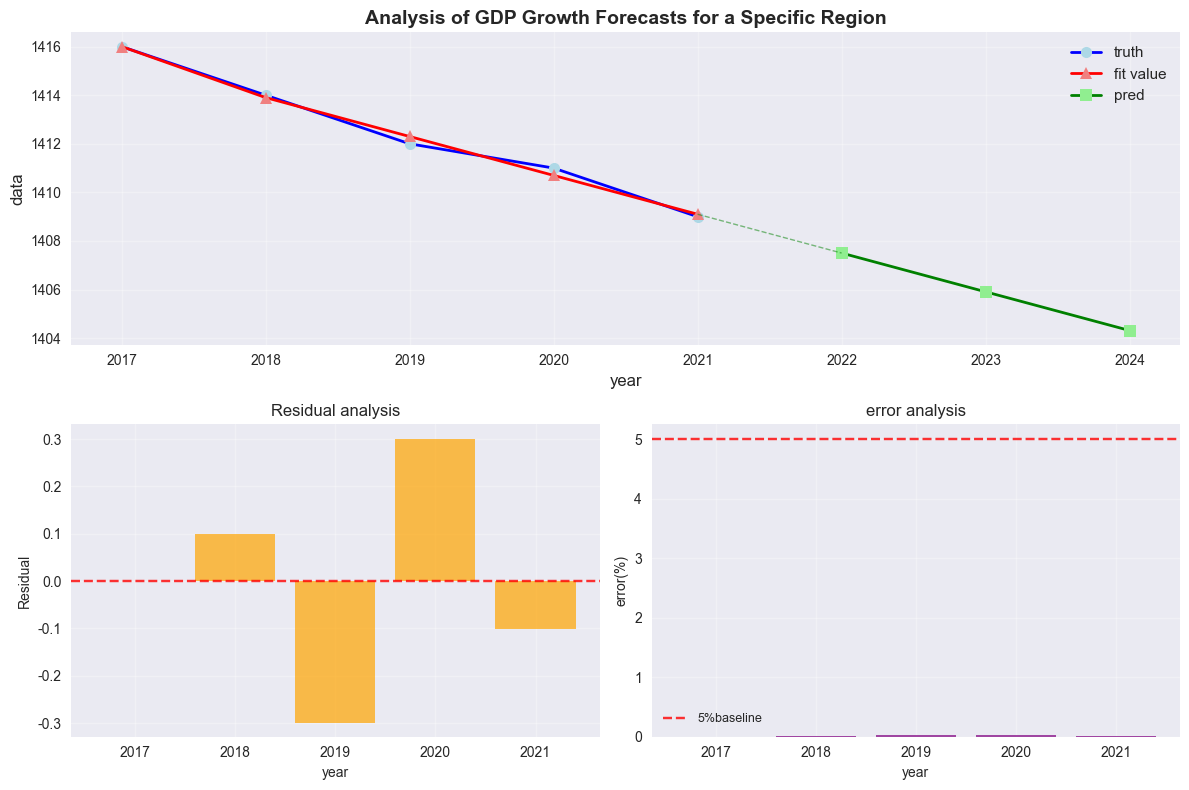

In [64]:
print(f"\n📊 生成可视化图表...")
gm_gdp.plot_results(gdp_data, years, future_years, predicted_values, 
                   "Analysis of GDP Growth Forecasts for a Specific Region")

# 模型适用性评估

In [57]:
print(f"\n✅ 模型适用性评估:")
print(f"1. 数据量检查: {len(gdp_data)}个观测值 ✓（GM(1,1)适合小样本）")
print(f"2. 级比检验: {'通过' if all(0.818 <= gdp_data[i-1]/gdp_data[i] <= 1.220 for i in range(1, len(gdp_data))) else '不通过'}")
print(f"3. 精度等级: {metrics['grade']}")
print(f"4. 数据趋势: 单调递增 ✓（适合GM(1,1)建模）")



✅ 模型适用性评估:
1. 数据量检查: 5个观测值 ✓（GM(1,1)适合小样本）
2. 级比检验: 通过
3. 精度等级: 一级（很好）
4. 数据趋势: 单调递增 ✓（适合GM(1,1)建模）


# 风险提示

In [58]:
print(f"\n⚠️  使用建议与风险提示:")
print(f"• 本模型适用于短期预测（1-3年），长期预测需谨慎使用")
print(f"• 预测结果基于历史趋势延续的假设，如遇重大政策变化或经济冲击可能失效")
print(f"• 建议结合其他预测方法进行对比验证")
print(f"• 模型精度为{metrics['grade']}，预测结果可作为参考依据")

print(f"\n" + "="*60)
print("案例一：GDP增长预测 - 分析完成！")
print("="*60)


⚠️  使用建议与风险提示:
• 本模型适用于短期预测（1-3年），长期预测需谨慎使用
• 预测结果基于历史趋势延续的假设，如遇重大政策变化或经济冲击可能失效
• 建议结合其他预测方法进行对比验证
• 模型精度为一级（很好），预测结果可作为参考依据

案例一：GDP增长预测 - 分析完成！
